# UBS Feature Selection

In this section we will continute data preprocessing steps in order to facilitate feature selection critera

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

In [20]:
# read in full UBS dataset (2019 - 2022)
df = pd.read_csv("UBS_Cleaned_Date.csv")

In [21]:
# Change "date" column to ensure datetime type and drop weekends
df["date"] = pd.to_datetime(df["date"])

In [22]:
# Drop first 14 dates
df = df.iloc[14:-1, :].reset_index(drop = True)
df.shape

(796, 201)

In [23]:
# Remove any infinitly large or small values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [24]:
# Drop remanining NaN or null values
df = df.dropna()
df.shape

(748, 201)

In [25]:
# Create X feature dataset
X = df.drop(["date", "target_1", "target_2", "target_3", "target_4", "target_5"], axis=1)

# Create y target dataset
y = df["target_1"]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Lasso Regression

Use lasso regression to find which features have coefficeints significantly different than zero. Those that are should be considered for inclusion in the models

In [27]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso())
])

search = GridSearchCV(pipeline,
                       {'model__alpha': np.arange(0.1, 10, 0.1)},
                        cv=10,
scoring = 'neg_mean_squared_error', verbose = 3
)

search.fit(X_train, y_train)
search.best_params_

coefficients = search.best_estimator_.named_steps['model'].coef_

importance = np.abs(coefficients)
importance

Fitting 10 folds for each of 99 candidates, totalling 990 fits
[CV 1/10] END ..............................model__alpha=0.1; total time=   0.1s
[CV 2/10] END ..............................model__alpha=0.1; total time=   0.0s
[CV 3/10] END ..............................model__alpha=0.1; total time=   0.0s
[CV 4/10] END ..............................model__alpha=0.1; total time=   0.0s
[CV 5/10] END ..............................model__alpha=0.1; total time=   0.0s
[CV 6/10] END ..............................model__alpha=0.1; total time=   0.0s
[CV 7/10] END ..............................model__alpha=0.1; total time=   0.0s
[CV 8/10] END ..............................model__alpha=0.1; total time=   0.0s
[CV 9/10] END ..............................model__alpha=0.1; total time=   0.1s
[CV 10/10] END .............................model__alpha=0.1; total time=   0.1s
[CV 1/10] END ..............................model__alpha=0.2; total time=   0.1s
[CV 2/10] END ..............................mo

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.16897186, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

### SelectKBest 

In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# scale the data to be between 0 and 1. Chi2 doesn't allow for negative values


# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
best_fit = bestfeatures.fit(X, y)
best_scores = pd.DataFrame(best_fit.scores_)
best_columns = pd.DataFrame(X.columns)

# concatenate the dataframes for better visualization
features_score = pd.concat([best_columns, best_scores], axis=1)
features_score.columns = ['Features', 'Score']  # naming the dataframe columns
print(features_score.nlargest(25, 'Score'))  # print the top 25 best features

                    Features       Score
56              Change_Close  313.546149
66             Wiki_RSI_Move    7.953919
192       Dow_Disparity_Move    5.951264
59            Wiki_MAvg_Move    5.017463
154                 Nas_Move    4.581971
88                 Google_rs    4.294823
93           Google_ROC_Move    4.061060
160       Nas_Disparity_Move    3.780974
97   Google_Disparity_s_Move    3.778765
161     Nas_Disparity_s_Move    3.604700
84               Google_gain    3.385177
193     Dow_Disparity_s_Move    3.349542
98           Google_RSI_Move    3.227221
83               Google_diff    3.168724
186                 Dow_Move    2.980363
70         Google_Moment_2_s    2.105778
176                 Dow_Rocp    2.044336
148                 Nas_gain    2.039677
40          Wiki_Disparity_s    2.005270
156          Nas_MAvg_s_Move    1.989034
90               Google_Move    1.908364
76        Google_Disparity_s    1.877253
27              Google_total    1.842870
12              

/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


### Feature Importance with ExtraTreesClassifier

[6.80291656e-03 4.86285832e-04 3.13943680e-03 8.59087301e-05
 3.59693099e-03 3.32273369e-03 4.58810874e-03 4.01005611e-03
 4.12259713e-03 6.85706784e-03 2.41574527e-04 0.00000000e+00
 5.04512159e-03 5.19879046e-03 4.64913292e-03 5.33268732e-03
 3.97361229e-03 4.24154975e-03 3.34164263e-03 3.83798123e-03
 5.34036456e-03 4.20727431e-03 3.85649021e-03 3.88121361e-03
 4.13713187e-03 5.56471209e-03 5.78463044e-03 5.29561799e-03
 4.60380978e-03 4.26098981e-03 4.35125138e-03 5.22662814e-03
 5.15496584e-03 4.47907417e-03 4.50908271e-03 4.67077617e-03
 4.70690963e-03 5.11017228e-03 4.73376378e-03 5.37055294e-03
 5.94017729e-03 5.42990049e-03 4.78064129e-03 5.22761153e-03
 5.70820752e-03 4.77943914e-03 4.38752072e-03 5.24143520e-03
 5.13652117e-03 4.81050139e-03 4.92917245e-03 5.42408683e-03
 6.33633523e-03 5.24258494e-03 5.44114957e-03 6.04464702e-03
 6.92538386e-02 5.64498042e-03 3.63403858e-03 5.30845160e-03
 4.77120502e-03 5.53908098e-03 4.18683625e-03 4.18509189e-03
 4.39381296e-03 4.173663

<AxesSubplot:>

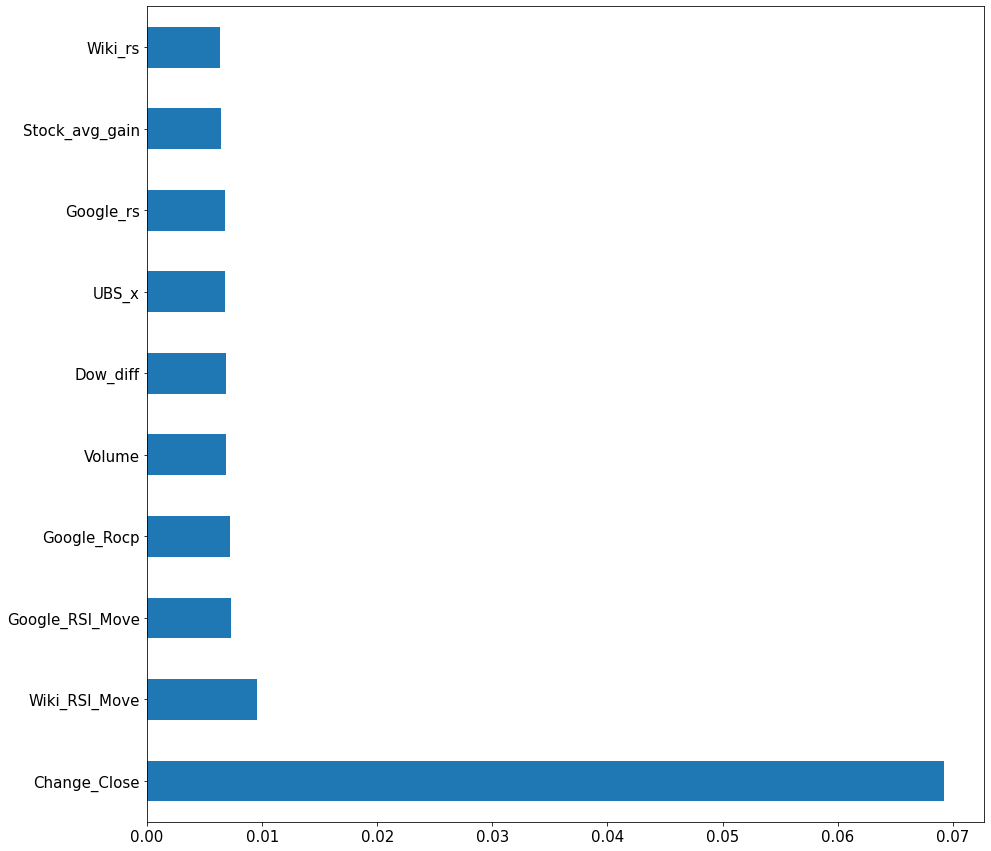

In [29]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X, y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', figsize=(15,15), fontsize=(15))